# Setting up the Environment

In [ ]:
import os
from google.colab import drive

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
WORKING_DIRECTORY = 'drive/MyDrive/Music Generation/Mix Music Generation'

In [ ]:
os.chdir(WORKING_DIRECTORY)

# Data Ingestion

In [ ]:
!pip install PyGithub

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.9/302.9 kB 4.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 856.7/856.7 kB 14.9 MB/s eta 0:00:00
  Attempting uninstall: pyjwt
    Found existing installation: PyJWT 2.3.0
    Uninstalling PyJWT-2.3.0:
      Successfully uninstalled PyJWT-2.3.0


In [ ]:
import os
import requests
from pathlib import Path
from github import Github,ContentFile,Repository

In [ ]:
REPOSITORY = Path('Gourav052003/Mix-Music-Splitter-Dataset')
FOLDER = Path('Mix Music')
SAVE_FOLDER = Path('Artifacts/Dataset')
META_DATA_FILE_PATH = Path('MUSIC-2.0/Meta_data.csv')

In [ ]:
def download(c: ContentFile, out: str):

  r = requests.get(c.download_url)
  output_path = Path(f'{out}/{c.path}')
  os.makedirs(os.path.dirname(output_path), exist_ok=True)

  with open(output_path, 'wb') as f:
      print(f'downloading {c.path} to {out}')
      f.write(r.content)

In [ ]:
def git_download_folder(repository:Repository, folder: str, save_dir_name: str):

  folder = repository.get_contents(folder)

  for sub_folder in folder:

    if sub_folder.download_url is None:

      git_download_folder(repository,sub_folder.path,save_dir_name)

      continue

    download(sub_folder,save_dir_name)

In [ ]:
github_object = Github()
repository = github_object.get_repo(REPOSITORY.as_posix())

In [ ]:
git_download_folder(repository,FOLDER.as_posix(),SAVE_FOLDER.as_posix())

downloading Mix Music/a-small-miracle-132333.mp3 to Artifacts/Dataset
downloading Mix Music/abstract-fashion-pop-131283.mp3 to Artifacts/Dataset
downloading Mix Music/abstract-future-bass-162604.mp3 to Artifacts/Dataset
downloading Mix Music/acoustic-guitars-ambient-uplifting-background-music-for-videos-5642.mp3 to Artifacts/Dataset
downloading Mix Music/ambient-classical-guitar-144998.mp3 to Artifacts/Dataset
downloading Mix Music/ambient-piano-ampamp-strings-10711.mp3 to Artifacts/Dataset
downloading Mix Music/anthem-of-victory-111206.mp3 to Artifacts/Dataset
downloading Mix Music/awaken-136824.mp3 to Artifacts/Dataset
downloading Mix Music/awakening-instrumental-1165.mp3 to Artifacts/Dataset
downloading Mix Music/baby-mandala-169039.mp3 to Artifacts/Dataset
downloading Mix Music/background-music-for-short-funny-video-vlog-advertising-podcast-170014.mp3 to Artifacts/Dataset
downloading Mix Music/background-music-for-vlog-video-i-met-you-in-dallas-funny-rhythms-167731.mp3 to Artifacts

In [ ]:
# download(repository.get_contents(META_DATA_FILE_PATH.as_posix()),SAVE_FOLDER.as_posix())

downloading MUSIC-2.0/Meta_data.csv to Artifacts/Dataset


# Data Validation

In [ ]:
import os
import shutil
import numpy as np
from glob import glob
import pandas as pd
from pathlib import Path
from sys import platform
from sklearn.model_selection import train_test_split

In [ ]:
META_DATA_FILE_PATH = Path('Artifacts/Dataset/MUSIC-2.0/Meta_data.csv')

In [ ]:
MUSIC_FILES = np.array(os.listdir("Artifacts/Dataset/Mix Music"))

In [ ]:
SOURCE_MUSIC_DIRECTORY = Path("Artifacts/Dataset/Mix Music")

MUSIC_DIRECTORY = [Path("Artifacts/train/Mix Music"),
                        Path("Artifacts/validation/Mix Music"),
                        Path("Artifacts/test/Mix Music")]

In [ ]:
def train_validation_test_splitting(music_files):

#   meta_data = pd.read_csv(meta_data_filename)

  train,test = train_test_split(music_files,test_size = 0.2,shuffle = True)
  train,validation = train_test_split(train,test_size = 0.2,shuffle = True)

  return train,validation,test

In [ ]:
def copy_to(filenames,source_music_dir,destination_music_dir):

#   filenames = filenames.filename.values

  for filename in filenames:

    source_music_path = Path(os.path.join(source_music_dir,filename))
    shutil.copy2(source_music_path,destination_music_dir)


In [ ]:
def execute_splitting(music_dir,train,validation,test,source_music_dir):

    for m_dir in music_dir:

      os.makedirs(m_dir,exist_ok = True)

      for music_file in os.listdir(m_dir):
        if music_file != '.ipynb_checkpoints':
          os.remove(Path(os.path.join(m_dir,music_file)))


    copy_to(train,source_music_dir,music_dir[0])
    copy_to(validation,source_music_dir,music_dir[1])
    copy_to(test,source_music_dir,music_dir[2])


In [ ]:
train,validation,test = train_validation_test_splitting(MUSIC_FILES)

In [ ]:
execute_splitting(MUSIC_DIRECTORY,train,validation,test,SOURCE_MUSIC_DIRECTORY)

# Data Preparation

In [ ]:
import os
import numpy as np
import librosa as lbrs
from pathlib import Path
from glob import glob
from tqdm import tqdm

In [ ]:
TRAIN_MUSIC_DIRECTORY = Path("Artifacts/train/Mix Music")
VALIDATION_MUSIC_DIRECTORY = Path("Artifacts/validation/Mix Music")
TEST_MUSIC_DIRECTORY = Path("Artifacts/test/Mix Music")

In [ ]:
def prepare_data(MUSIC_DIRECTORY,duration = 30,input_timestamp=20,output_timestamp=10):


    music_files_features = []

    filenames = glob(MUSIC_DIRECTORY+'/*')

    features,sample_rate = lbrs.load(filenames[0],duration = duration)

    all_timestamp_data = []

    timestamp_intervals = list(range(0,len(features)+sample_rate,sample_rate))

    for start_timestamp_no in tqdm(range(len(timestamp_intervals)-1)):

        timestamp_features = []

        for filename in filenames:

            features,sample_rate = lbrs.load(filename,duration = duration)

            one_second_features = features[timestamp_intervals[start_timestamp_no]:timestamp_intervals[start_timestamp_no+1]]

            timestamp_features.append(one_second_features)


        all_timestamp_data.append(timestamp_features)


    input_timestamp_data = []
    output_timestamp_data = []

    for timestamp_data in all_timestamp_data:

        if len(input_timestamp_data)<input_timestamp:
            input_timestamp_data.append(np.array(timestamp_data))

        elif len(output_timestamp_data)<output_timestamp:
            output_timestamp_data.append(np.array(timestamp_data))


    return input_timestamp_data,output_timestamp_data,sample_rate



In [ ]:
input_data,output_data,sample_rate = prepare_data(TRAIN_MUSIC_DIRECTORY.as_posix())

In [ ]:
t_input,t_output,sample_rate = prepare_data(TEST_MUSIC_DIRECTORY.as_posix())

100%|██████████| 30/30 [02:50<00:00,  5.69s/it]


In [ ]:
v_input,v_output,sample_rate = prepare_data(VALIDATION_MUSIC_DIRECTORY.as_posix())

100%|██████████| 30/30 [03:05<00:00,  6.19s/it]


# Model Archtecture Development

In [ ]:
from keras.layers import Input,Dense,Add,Dropout,BatchNormalization,Concatenate,Reshape,Flatten,LeakyReLU
from keras.optimizers import Adam
from keras import Model
import numpy as np

In [ ]:

def hidden_layers(bn1,unit_no,architecture_type = None):
    du1 = Dense(64,name = f"{architecture_type}_dense_1_unit_{unit_no}")(bn1)
    lr1 = LeakyReLU(0.3,name = f"{architecture_type}_leakyRelu_1_unit_{unit_no}")(du1)
    bn1 = BatchNormalization(name = f"{architecture_type}_batch_norm_hidden_1_{unit_no}")(lr1)
    # drp1 = Dropout(0.1,name = f"{architecture_type}_dropout_1_unit_{unit_no}")(bn1)

    du2 = Dense(128,name = f"{architecture_type}_dense_2_unit_{unit_no}")(bn1)
    lr2 = LeakyReLU(0.3,name = f"{architecture_type}_leakyRelu_2_unit_{unit_no}")(du2)
    bn2 = BatchNormalization(name = f"{architecture_type}_batch_norm_hidden_2_{unit_no}")(lr2)
    # drp2 = Dropout(0.1,name = f"{architecture_type}_dropout_2_unit_{unit_no}")(bn2)

    du3 = Dense(256,name = f"{architecture_type}_dense_3_unit_{unit_no}")(bn2)
    lr3 = LeakyReLU(0.3,name = f"{architecture_type}_leakyRelu_3_unit_{unit_no}")(du3)
    bn3 = BatchNormalization(name = f"{architecture_type}_batch_norm_hidden_3_{unit_no}")(lr3)
    # drp3 = Dropout(0.1,name = f"{architecture_type}_dropout_3_unit_{unit_no}")(bn3)

    du4 = Dense(512,name = f"{architecture_type}_dense_4_unit_{unit_no}")(bn3)
    lr4 = LeakyReLU(0.3,name = f"{architecture_type}_leakyRelu_4_unit_{unit_no}")(du4)
    bn4 = BatchNormalization(name = f"{architecture_type}_batch_norm_hidden_4_{unit_no}")(lr4)
    # drp4 = Dropout(0.1,name = f"{architecture_type}_dropout_4_unit_{unit_no}")(bn4)

    return bn4


In [ ]:
def relation_neural_network(i=None,ou=None,inter_i=None,unit_no=None,architecture_type=None,sample_rate=22050,timestamp=20):

  if architecture_type == 'encoder':

    ou.append(i)
    print("e")
    c1 = Concatenate(name = f"{architecture_type}_rel_nn_concatenate_1_unit_{unit_no}")(ou)
    r1 = Reshape((sample_rate,timestamp))(c1)
    d1 = Dense(1,name = f"{architecture_type}_rel_nn_dense_1_unit_{unit_no}")(r1)
    l1 = LeakyReLU(alpha = 0.4)(d1)
    f1 = Flatten()(l1)
    return f1

  elif architecture_type=='inter':
    print("i")
    c1 = Concatenate(name = f"{architecture_type}_rel_nn_concatenate_1_unit_{unit_no}")(inter_i)
    r1 = Reshape((sample_rate,timestamp))(c1)
    d1 = Dense(1,name = f"{architecture_type}_rel_nn_dense_1_unit_{unit_no}")(r1)
    l1 = LeakyReLU(alpha = 0.4)(d1)
    f1 = Flatten()(l1)
    return f1

  else:

    ou.append(i)
    print("d")
    c1 = Concatenate(name = f"{architecture_type}_rel_nn_concatenate_1_unit_{unit_no}")(ou)
    r1 = Reshape((sample_rate,timestamp))(c1)
    d1 = Dense(1,name = f"{architecture_type}_rel_nn_dense_1_unit_{unit_no}")(r1)
    l1 = LeakyReLU(alpha = 0.4)(d1)
    f1 = Flatten()(l1)
    return f1


In [ ]:
def Encoder_Decoder_model(sample_rate=22050,encoder_timestamp=20,decoder_timestamp = 10):

    encoder_input_units = []
    encoder_output_units = []
    decoder_output_units = []

    i,du,lu,ou = None,None,None,None

    for unit_no in range(encoder_timestamp):

        if unit_no == 0:
            i = Input((sample_rate),name = f"encoder_Input_1_unit_{unit_no}")
            r = relation_neural_network(i = i,ou = [i],inter_i = None,unit_no = unit_no,architecture_type="encoder",sample_rate = sample_rate,timestamp = 2)
            # print(r)
            h = hidden_layers(r,unit_no,architecture_type = "encoder")
            d = Dense(sample_rate)(h)
            ou = LeakyReLU(alpha = 1)(d)



        else:
            i = Input((sample_rate),name = f"encoder_Input_1_unit_{unit_no}")

            r = relation_neural_network(i = i,ou = encoder_output_units.copy(),inter_i = None,unit_no = unit_no,architecture_type="encoder",sample_rate = sample_rate,timestamp = unit_no+1)
            h = hidden_layers(r,unit_no,architecture_type = "encoder")
            d = Dense(sample_rate)(h)
            ou = LeakyReLU(alpha = 1)(d)

        encoder_input_units.append(i)
        encoder_output_units.append(ou)


    r = relation_neural_network(inter_i = encoder_output_units.copy(),unit_no = 777,architecture_type="inter",sample_rate = sample_rate,timestamp = 20)
    h = hidden_layers(r,unit_no,architecture_type = "inter")
    d = Dense(sample_rate)(h)
    inter_i = LeakyReLU(alpha = 1)(d)

    for unit_no in range(decoder_timestamp):

        if unit_no == 0:

            r = relation_neural_network(i = inter_i,ou = [inter_i],inter_i = None,unit_no = unit_no,architecture_type="decoder",sample_rate = sample_rate,timestamp = 2)
            h = hidden_layers(r,unit_no,architecture_type = "decoder")
            d = Dense(sample_rate)(h)
            ou = LeakyReLU(alpha = 1)(d)
        else:

            r = relation_neural_network(i = inter_i,ou = decoder_output_units.copy(),inter_i = None,unit_no = unit_no,architecture_type="decoder",sample_rate = sample_rate,timestamp = unit_no+1)
            h = hidden_layers(r,unit_no,architecture_type = "decoder")
            d = Dense(sample_rate)(h)
            ou = LeakyReLU(alpha = 1)(d)

        decoder_output_units.append(ou)

    return encoder_input_units,decoder_output_units


In [ ]:
encoder_input_units,decoder_output_units = Encoder_Decoder_model(sample_rate=22050)

In [ ]:
model = Model(inputs = encoder_input_units,outputs = decoder_output_units)

In [ ]:
model.compile(optimizer = Adam(learning_rate=0.001),loss='mse')

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 encoder_Input_1_unit_0 (In  [(None, 22050)]              0         []                            
 putLayer)                                                                                        
                                                                                                  
 encoder_rel_nn_concatenate  (None, 44100)                0         ['encoder_Input_1_unit_0[0][0]
 _1_unit_0 (Concatenate)                                            ',                            
                                                                     'encoder_Input_1_unit_0[0][0]
                                                                    ']                            
                                                                                              

In [ ]:
from keras.utils import plot_model

In [ ]:
plot_model(model)

In [ ]:
from keras.callbacks import ModelCheckpoint
model_checkpoint = ModelCheckpoint(save_best_only = True,filepath = 'best_model.h5')

In [ ]:
# model_history = model.fit(x = t_input,y = t_output,epochs = 200,batch_size=10,validation_data=(v_input,v_output),validation_batch_size = 10,callbacks = [model_checkpoint])
model_history = model.fit(x = t_input,y = t_output,epochs = 500,batch_size=10)

In [ ]:
np.array(t_input).shape

(20, 37, 22050)

# Model Testing

In [ ]:
def prepare_output(data,index):
    test = []
    for i in data:

        test.append(i[index].reshape(1,22050))

    return test


In [ ]:
from IPython.display import Audio
p = prepare_output(t_input,2)
Audio(np.array(p).flatten(),rate = sample_rate)

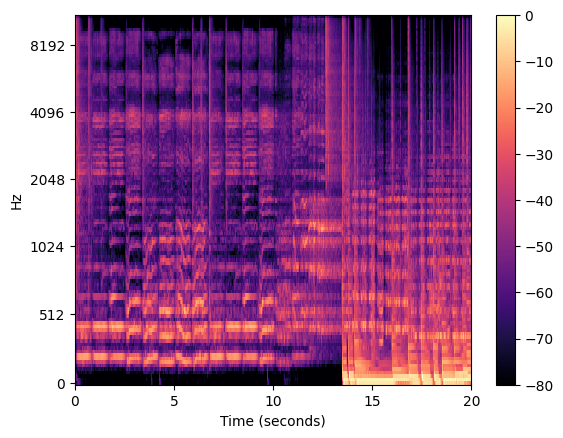

In [ ]:
spec = librosa.feature.melspectrogram(y=np.array(p).flatten(), sr=22050)
db_spec = librosa.power_to_db(spec, ref=np.max,)
librosa.display.specshow(db_spec,y_axis='mel', x_axis='s', sr=22050)
plt.colorbar()

In [ ]:
import librosa
import librosa.display

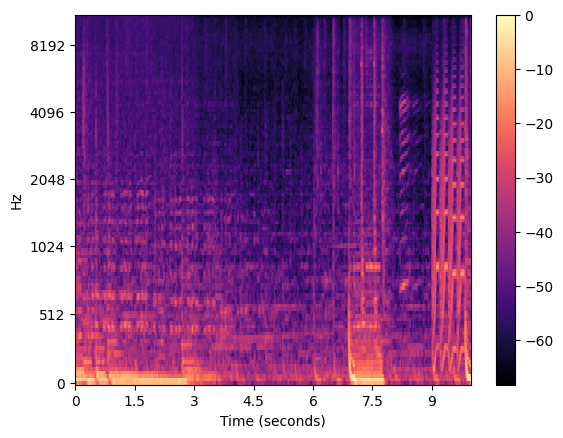

In [ ]:
spec = librosa.feature.melspectrogram(y=p, sr=22050)
db_spec = librosa.power_to_db(spec, ref=np.max,)
librosa.display.specshow(db_spec,y_axis='mel', x_axis='s', sr=22050)
plt.colorbar()

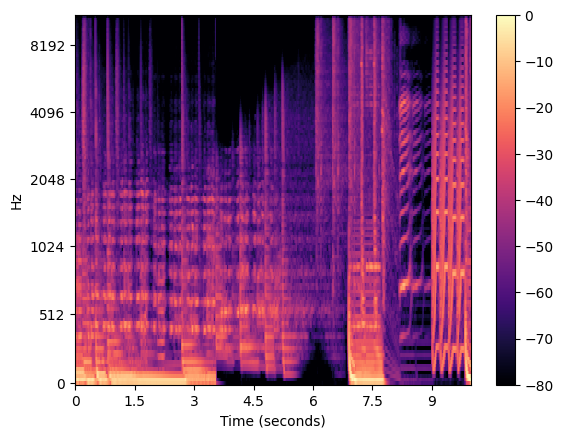

In [ ]:
p = prepare_output(t_output,2)
spec = librosa.feature.melspectrogram(y=np.array(p).flatten(), sr=22050)
db_spec = librosa.power_to_db(spec, ref=np.max,)
librosa.display.specshow(db_spec,y_axis='mel', x_axis='s', sr=22050)
# plt.figure(figsize = (15,5))
plt.colorbar()

In [ ]:
p = prepare_output(t_input,2)
p = model.predict(p)
p = np.array(p).flatten()
Audio(p,rate = sample_rate)

1/1 [==============================] - 6s 6s/step


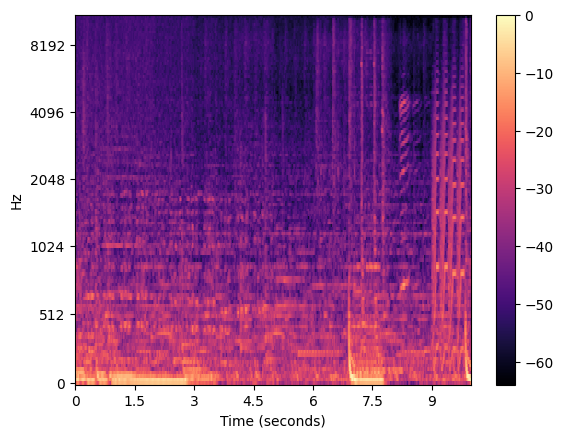

In [ ]:
spec = librosa.feature.melspectrogram(y=p, sr=22050)
db_spec = librosa.power_to_db(spec, ref=np.max,)
librosa.display.specshow(db_spec,y_axis='mel', x_axis='s', sr=22050)
plt.colorbar()

In [ ]:
from glob import glob
import librosa as lbrs
from IPython.display import Audio

In [ ]:
file_path = glob(TEST_MUSIC_DIRECTORY.as_posix()+'/*')[0]

In [ ]:
f,sr = lbrs.load(file_path)
duration = lbrs.get_duration(y = f,sr=sr)
f,sr = lbrs.load(file_path,offset=duration-20)
Audio(f,rate = sr)


In [ ]:
from keras.models import load_model

In [ ]:
m = load_model('best_model.h5')

In [ ]:
f[:20]

array([-0.07466184, -0.11937276, -0.11142707, -0.12679313, -0.12785968,
       -0.13970828, -0.14250495, -0.15182811, -0.15195303, -0.15391695,
       -0.15033121, -0.15013349, -0.14708143, -0.14666483, -0.14591238,
       -0.14690107, -0.1465555 , -0.14279902, -0.1369371 , -0.13211653],
      dtype=float32)

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
model_history.history.keys()

dict_keys(['loss', 'flatten_21_loss', 'flatten_22_loss', 'flatten_23_loss', 'flatten_24_loss', 'flatten_25_loss', 'flatten_26_loss', 'flatten_27_loss', 'flatten_28_loss', 'flatten_29_loss', 'flatten_30_loss', 'val_loss', 'val_flatten_21_loss', 'val_flatten_22_loss', 'val_flatten_23_loss', 'val_flatten_24_loss', 'val_flatten_25_loss', 'val_flatten_26_loss', 'val_flatten_27_loss', 'val_flatten_28_loss', 'val_flatten_29_loss', 'val_flatten_30_loss'])

In [ ]:
history = []


In [ ]:
old_model_history = model_history.history.copy()
history.append(old_model_history)

In [ ]:
history[0].keys()

dict_keys(['loss', 'leaky_re_lu_43_loss', 'leaky_re_lu_45_loss', 'leaky_re_lu_47_loss', 'leaky_re_lu_49_loss', 'leaky_re_lu_51_loss', 'leaky_re_lu_53_loss', 'leaky_re_lu_55_loss', 'leaky_re_lu_57_loss', 'leaky_re_lu_59_loss', 'leaky_re_lu_61_loss'])

In [ ]:
loss = [[] for key in history[0].keys() for hist in history for h in history ]

In [ ]:
len(loss)

600

In [ ]:
unit_loss = model_history.history['loss'][:30]
unit_0_loss = model_history.history['flatten_21_loss'][:30]
unit_1_loss = model_history.history['flatten_22_loss'][:30]
unit_2_loss = model_history.history['flatten_23_loss'][:30]
unit_3_loss = model_history.history['flatten_24_loss'][:30]
unit_4_loss = model_history.history['flatten_25_loss'][:30]
unit_5_loss = model_history.history['flatten_26_loss'][:30]
unit_6_loss = model_history.history['flatten_27_loss'][:30]
unit_7_loss = model_history.history['flatten_28_loss'][:30]
unit_8_loss = model_history.history['flatten_29_loss'][:30]
unit_9_loss = model_history.history['flatten_30_loss'][:30]


In [ ]:
val_unit_loss = model_history.history['val_loss'][:30]
val_unit_0_loss = model_history.history['val_flatten_21_loss'][:30]
val_unit_1_loss = model_history.history['val_flatten_22_loss'][:30]
val_unit_2_loss = model_history.history['val_flatten_23_loss'][:30]
val_unit_3_loss = model_history.history['val_flatten_24_loss'][:30]
val_unit_4_loss = model_history.history['val_flatten_25_loss'][:30]
val_unit_5_loss = model_history.history['val_flatten_26_loss'][:30]
val_unit_6_loss = model_history.history['val_flatten_27_loss'][:30]
val_unit_7_loss = model_history.history['val_flatten_28_loss'][:30]
val_unit_8_loss = model_history.history['val_flatten_29_loss'][:30]
val_unit_9_loss = model_history.history['val_flatten_30_loss'][:30]

Text(0, 0.5, 'loss')

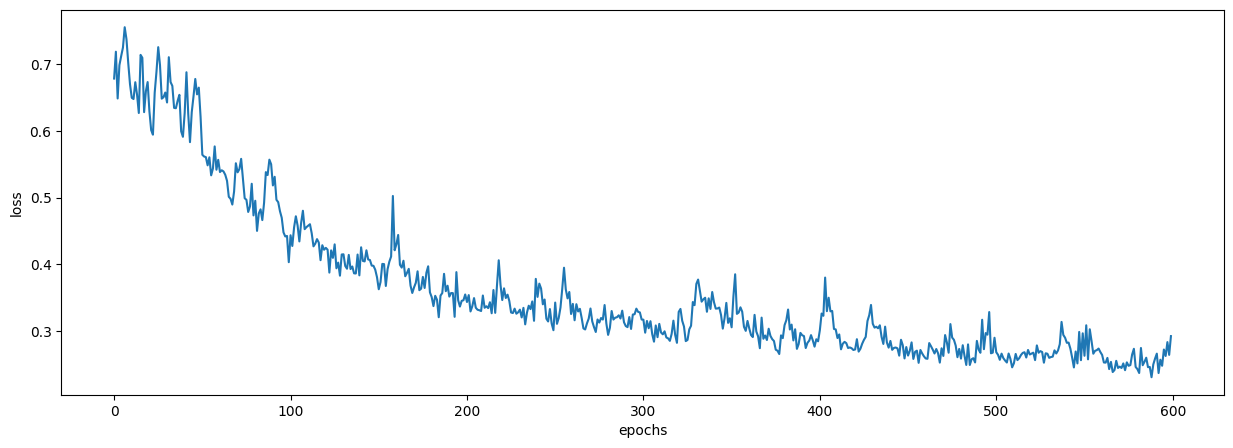

In [ ]:
plt.figure(figsize = (15,5))
plt.plot(loss)
plt.xlabel('epochs')
plt.ylabel('loss')
# plt.plot(val_unit_loss)

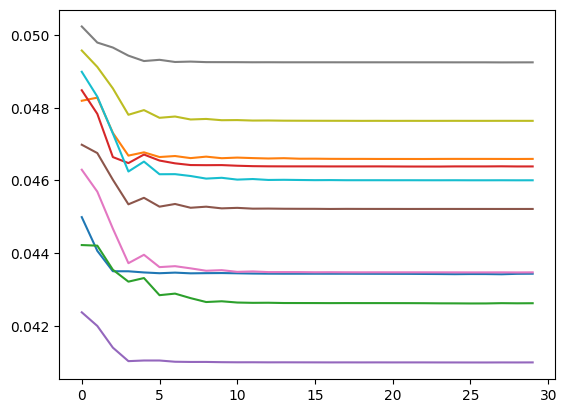

In [ ]:
plt.plot(unit_0_loss)
plt.plot(unit_1_loss)
plt.plot(unit_2_loss)
plt.plot(unit_3_loss)
plt.plot(unit_4_loss)
plt.plot(unit_5_loss)
plt.plot(unit_6_loss)
plt.plot(unit_7_loss)
plt.plot(unit_8_loss)
plt.plot(unit_9_loss)

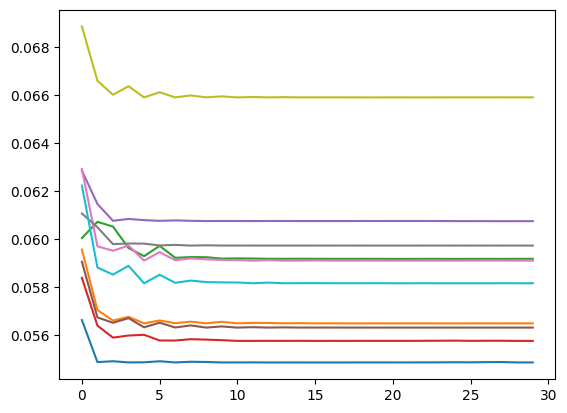

In [ ]:
plt.plot(val_unit_0_loss)[:200]
plt.plot(val_unit_1_loss)[:200]
plt.plot(val_unit_2_loss)[:200]
plt.plot(val_unit_3_loss)[:200]
plt.plot(val_unit_4_loss)[:200]
plt.plot(val_unit_5_loss)[:200]
plt.plot(val_unit_6_loss)[:200]
plt.plot(val_unit_7_loss)[:200]
plt.plot(val_unit_8_loss)[:200]
plt.plot(val_unit_9_loss)[:200]